In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Memuat data train dari file excel menggunakan Pandas
df_train = pd.read_excel('D:/Data/Kuliah/TA/Projek-Capstone-Design/DATA/Preprocessing/balance data train 80%.xlsx')

# Memuat data test dari file excel menggunakan Pandas
df_test = pd.read_excel('D:/Data/Kuliah/TA/Projek-Capstone-Design/DATA/Preprocessing/balance data testing 20%.xlsx')

# mengubah kategori menjadi angka
category_mapping = {
    'baik': 1,
    'sedang': 2,
    'tidak sehat': 3,
    'sangat tidak sehat': 4
}

# Gunakan fungsi map untuk mengganti kategori dengan nilai numerik yang sesuai
df_train['Kategori'] = df_train['Kategori'].map(category_mapping)
df_test['Kategori'] = df_test['Kategori'].map(category_mapping)

# Bagi data train dan test menjadi fitur (X) dan target (y)
X_train = df_train.drop('Kategori', axis=1)
y_train = df_train['Kategori']

X_test = df_test.drop('Kategori', axis=1)
y_test = df_test['Kategori']

# Lakukan preprocessing StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

-----------------------------------------------------
classifier train accuracy: 0.97125
classifier test accuracy: 0.965
classifier running time: 0.07507850002730265
Akurasi model dengan membuang 15% data: 96.5 %
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       100
           2       0.95      0.92      0.93       100
           3       0.97      0.96      0.96       100
           4       0.99      1.00      1.00       100

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



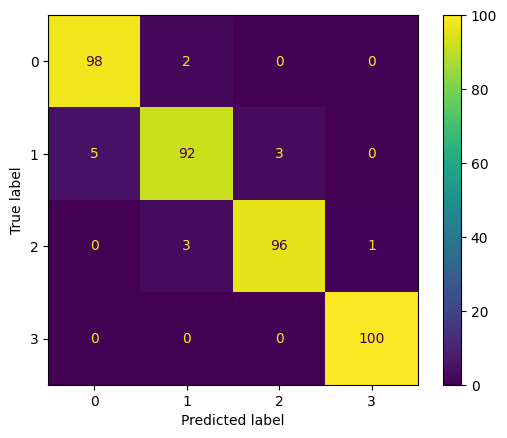

In [2]:
from numpy.linalg import pinv, inv
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

class elm():
    def __init__(self, hidden_units, activation_function, x, y, C, elm_type, one_hot=True, random_type='normal'):
        self.hidden_units = hidden_units
        self.activation_function = activation_function
        self.random_type = random_type
        self.x = x
        self.y = y
        self.C = C
        self.class_num = np.unique(self.y).shape[0]
        self.beta = np.zeros((self.hidden_units, self.class_num))
        self.elm_type = elm_type
        self.one_hot = one_hot

        if elm_type == 'clf' and self.one_hot:
            self.one_hot_label = np.zeros((self.y.shape[0], self.class_num + 1))
            for i in range(self.y.shape[0]):
                self.one_hot_label[i, int(self.y[i])] = 1

        if self.random_type == 'uniform':
            self.W = np.random.uniform(low=0, high=1, size=(self.hidden_units, self.x.shape[1]))
            self.b = np.random.uniform(low=0, high=1, size=(self.hidden_units, 1))
        if self.random_type == 'normal':
            self.W = np.random.normal(loc=0, scale=0.5, size=(self.hidden_units, self.x.shape[1]))
            self.b = np.random.normal(loc=0, scale=0.5, size=(self.hidden_units, 1))

    def __input2hidden(self, x):
        self.temH = np.dot(self.W, x.T) + self.b

        if self.activation_function == 'sigmoid':
            self.H = 1 / (1 + np.exp(-self.temH))

        if self.activation_function == 'relu':
            self.H = self.temH * (self.temH > 0)

        if self.activation_function == 'sin':
            self.H = np.sin(self.temH)

        if self.activation_function == 'tanh':
            self.H = (np.exp(self.temH) - np.exp(-self.temH)) / (np.exp(self.temH) + np.exp(-self.temH))

        if self.activation_function == 'leaky_relu':
            self.H = np.maximum(0, self.temH) + 0.1 * np.minimum(0, self.temH)

        return self.H

    def __hidden2output(self, H):
        self.output = np.dot(H.T, self.beta)
        return self.output

    def fit(self, algorithm):
        self.time1 = time.perf_counter()
        self.H = self.__input2hidden(self.x)
        if self.elm_type == 'clf':
            if self.one_hot:
                self.y_temp = self.one_hot_label
            else:
                self.y_temp = self.y
        if self.elm_type == 'reg':
            self.y_temp = self.y

        if algorithm == 'no_re':
            self.beta = np.dot(pinv(self.H.T), self.y_temp)

        if algorithm == 'solution1':
            self.tmp1 = inv(np.eye(self.H.shape[0]) / self.C + np.dot(self.H, self.H.T))
            self.tmp2 = np.dot(self.tmp1, self.H)
            self.beta = np.dot(self.tmp2, self.y_temp)

        if algorithm == 'solution2':
            self.tmp1 = inv(np.eye(self.H.shape[0]) / self.C + np.dot(self.H, self.H.T))
            self.tmp2 = np.dot(self.H.T, self.tmp1)
            self.beta = np.dot(self.tmp2.T, self.y_temp)
        self.time2 = time.perf_counter()

        self.result = self.__hidden2output(self.H)

        if self.elm_type == 'clf':
            self.result = np.exp(self.result) / np.sum(np.exp(self.result), axis=1).reshape(-1, 1)

        if self.elm_type == 'clf':
            self.y_ = np.where(self.result == np.max(self.result, axis=1).reshape(-1, 1))[1]
            self.correct = 0
            for i in range(self.y.shape[0]):
                if self.y_[i] == self.y[i]:
                    self.correct += 1
            self.train_score = self.correct / self.y.shape[0]
        if self.elm_type == 'reg':
            self.train_score = np.sqrt(np.sum((self.result - self.y) * (self.result - self.y)) / self.y.shape[0])
        train_time = str(self.time2 - self.time1)
        return self.beta, self.train_score, train_time

    def predict(self, x):
        self.H = self.__input2hidden(x)
        self.y_ = self.__hidden2output(self.H)
        if self.elm_type == 'clf':
            self.y_ = np.where(self.y_ == np.max(self.y_, axis=1).reshape(-1, 1))[1]

        return self.y_

    def predict_proba(self, x):
        self.H = self.__input2hidden(x)
        self.y_ = self.__hidden2output(self.H)
        if self.elm_type == 'clf':
            self.proba = np.exp(self.y_) / np.sum(np.exp(self.y_), axis=1).reshape(-1, 1)
        return self.proba

    def score(self, x, y):
        self.prediction = self.predict(x)
        if self.elm_type == 'clf':
            self.correct = 0
            for i in range(y.shape[0]):
                if self.prediction[i] == y[i]:
                    self.correct += 1
            self.test_score = self.correct / y.shape[0]
        if self.elm_type == 'reg':
            self.test_score = np.sqrt(np.sum((self.result - self.y) * (self.result - self.y)) / self.y.shape[0])
        return self.test_score
    
import random
import numpy as np

random.seed(42)
np.random.seed(42)

model = elm(hidden_units=500, activation_function='sigmoid', C=100, elm_type='clf', random_type='normal',
            x=X_train_scaled, y=y_train.astype(int).values.reshape(-1, 1))# Mengubah dimensi y_train menjadi (n_samples, 1)
beta, train_accuracy, running_time = model.fit('solution2')
prediction = model.predict(X_test_scaled)

print('-----------------------------------------------------')
print("classifier train accuracy:", train_accuracy)
print('classifier test accuracy:', model.score(X_test_scaled, y_test.values.reshape(-1, 1)))  # Mengubah dimensi y_test menjadi (n_samples, 1)
print('classifier running time:', running_time)
print('Akurasi model dengan membuang 15% data:', np.round(np.mean(prediction == y_test) * 100, 2), '%')

cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test, prediction)
print(report)

In [3]:
result_train_df = pd.DataFrame({'Actual': y_test,
                                'Predict': prediction})
print(result_train_df)

     Actual  Predict
0         3        3
1         4        4
2         1        1
3         2        2
4         3        3
..      ...      ...
395       4        4
396       2        2
397       4        4
398       2        2
399       4        4

[400 rows x 2 columns]


-----------------------------------------------------
classifier train accuracy (training data): 0.97125
Akurasi model pada data pelatihan: 97.12 %
Classification Report (training data):
              precision    recall  f1-score   support

           1       0.95      0.96      0.96       400
           2       0.95      0.94      0.94       400
           3       0.99      0.99      0.99       400
           4       1.00      1.00      1.00       400

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600



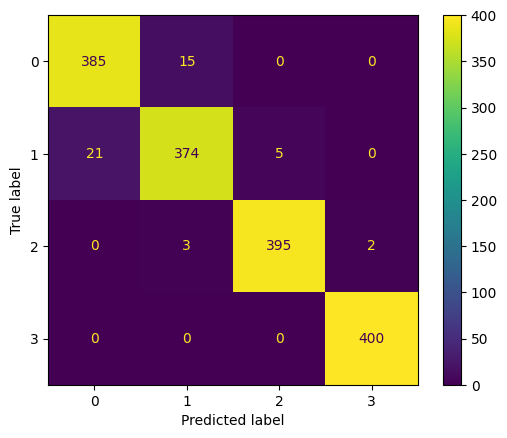

In [4]:
# Prediksi pada data pelatihan
train_prediction = model.predict(X_train_scaled)

# Akurasi dan laporan klasifikasi untuk data pelatihan
train_accuracy = model.score(X_train_scaled, y_train.values.reshape(-1, 1))
train_classification_report = classification_report(y_train, train_prediction)

# Matriks Konfusi untuk data pelatihan
cm_train = confusion_matrix(y_train, train_prediction)

# Tampilkan matriks konfusi menggunakan ConfusionMatrixDisplay
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()

# Cetak hasil akurasi dan laporan klasifikasi data pelatihan
print('-----------------------------------------------------')
print("classifier train accuracy (training data):", train_accuracy)
print('Akurasi model pada data pelatihan:', np.round(np.mean(train_prediction == y_train) * 100, 2), '%')
print('Classification Report (training data):')
print(train_classification_report)
